# Implementation details: deriving expected moment dynamics  
$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$
This notebook walks through what happens inside `compute_moment_evolutions()`.
We restate the algorithm outline, adding code snippets for each step.
This should help to track down issues when, unavoidably, something fails inside `compute_moment_evolutions()`.

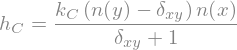

In [1]:
# initialize sympy printing (for latex output)
from sympy import init_printing
init_printing()

# import functions and classes for compartment models
from compartments import *
from compartments_display import *




# We only need one transition.
# We use "coagulation" from the coagulation-fragmentation example

D = 1 # number of species
x = ContentVar('x')
y = ContentVar('y')

transition_C = Transition(Compartment(x) + Compartment(y), Compartment(x + y), name = 'C')
k_C = Constant('k_C')
g_C = 1
pi_C = pi_c_identity()

transitions = [(transition_C, k_C, g_C, pi_C)]
display_transitions(transitions)

$$
\def\n{\mathbf{n}}
\def\x{\mathbf{x}}
\def\N{\mathbb{\mathbb{N}}}
\def\X{\mathbb{X}}
\def\NX{\mathbb{\N_0^\X}}
\def\C{\mathcal{C}}
\def\Jc{\mathcal{J}_c}
\def\DM{\Delta M_{c,j}}
\newcommand\diff{\mathop{}\!\mathrm{d}}
\def\Xc{\mathbf{X}_c}
\newcommand{\muset}[1]{\dot{\{}#1\dot{\}}}
$$


For a compartment population $\n \in \NX$ evolving stochastically according to stoichiometric equations from transition classes $\C$, we want to find an expression for
$$
\frac{\diff}{\diff t}\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>
$$
in terms of expectations of population moments $M^\alpha, M^{\beta}, \ldots$

In [2]:
fM = Moment(0)**2
display(fM)

### (1)
From the definition of the compartment dynamics, we have
$$
\diff M^\gamma = \sum_{c \in \C} \sum_{j \in \Jc} \DM^\gamma \diff R_{c,j}
$$
We apply Ito's rule to derive
$$
\diff f(M^\gamma, M^{\gamma'}, \ldots) = \sum_{c \in \C} \sum_{j \in \Jc}
    \left(
        f(M^\gamma + \DM^\gamma, M^{\gamma'} + \DM^{\gamma'}, \ldots)
        - f(M^\gamma, M^{\gamma'}, \ldots)
    \right) \diff R_{c,j}
$$

Assume, that $f(M^\gamma, M^{\gamma'}, \ldots)$ is a polynomial in $M^{\gamma^i}$ with $\gamma^i \in \N_0^D$.

Then $\diff f(M^\gamma, M^{\gamma'}, \ldots)$ is a polynomial in $M^{\gamma^k}, \DM^{\gamma^l}$ with $\gamma^k, \gamma^l \in \N_0^D$, that is,
$$
\diff f(M^\gamma, M^{\gamma'}, \ldots) = \sum_{c \in \C} \sum_{j \in \Jc}
    \sum_{q=1}^{n_q} Q_q(M^{\gamma^k}, \DM^{\gamma^l})
    \diff R_{c,j}
$$
where $Q_q(M^{\gamma^k}, \DM^{\gamma^l})$ are monomials in $M^{\gamma^k}, \DM^{\gamma^l}$.

In [3]:
dfM = ito(fM)
dfM

### (2)
Let's write $Q_q(M^{\gamma^k}, \DM^{\gamma^l})$ as
$$
Q_q(M^{\gamma^k}, \DM^{\gamma^l}) = k_q \cdot \Pi M^{\gamma^k} \cdot \Pi M^{\gamma^k}
$$
where $k_q$ is a constant,
  $\Pi M^{\gamma^k}$ is a product of powers of $M^{\gamma^k}$, and
  $\Pi \DM^{\gamma^l}$ is a product of powers of $\DM^{\gamma^l}$.
  
Analogous to the derivation in SI Appendix S.3, we arrive at the expected moment dynamics
$$
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t} =
    \sum_{c \in \C} \sum_{q=1}^{n_q} \left<
        \sum_{j \in \Jc} k_q \cdot \Pi M^{\gamma^k} \cdot \Pi \DM^{\gamma^k} \cdot h_{c,j}(\n)
    \right>
$$

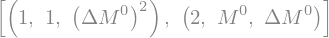

In [4]:
monomials = decomposeMomentsPolynomial(dfM)
monomials

### (3)
Analogous to SI Appendix S.4, the contribution of class $c$, monomial $q$ to the expected dynamics of $f(M^\gamma, M^{\gamma'}, \ldots)$ is
$$
\begin{align}
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t}
    &= \left<
        {\large\sum_{j \in \Jc}} k_q \cdot \Pi M^{\gamma^k} \cdot \Pi \DM^{\gamma^l} \cdot h_{c,j}(\n)
    \right>
    \\
    &= \left<
        {\large\sum_{\Xc}} w(\n; \Xc) \cdot k_c \cdot k_q \cdot \Pi M^{\gamma^k} \cdot g_c(\Xc) \cdot
        \left<
            \Pi \DM^{\gamma^l} \;\big|\; \Xc
        \right>
    \right>
\end{align}
$$


In [5]:
c = 0 # take the first transition class
q = 1 # ... and the second monomial

(transition, k_c, g_c, pi_c) = transitions[c]
(k_q, pM, pDM) = monomials[q]

First we compute the expression
$$
l(\n; \Xc) = k_c \cdot k_q \cdot \Pi(M^{\gamma^k}) \cdot g_c(\Xc) \cdot
        \left<
            \Pi \DM^{\gamma^l} \;\big|\; \Xc
        \right>
$$
We start by computing the $\DM^{\gamma^l}$ from reactants and products of the transition ...

In [6]:
reactants = getCompartments(transition.lhs)
products = getCompartments(transition.rhs)
DM_cj = getDeltaM(reactants, products, D)
DM_cj

... and then substituting this expression into every occurence of $\DM^\gamma$ in `pDM` (with the $\gamma$ in `DM_cj` set appropriately).

In [7]:
pDMcj = subsDeltaM(pDM, DM_cj)
print('pDM = ')
display(pDM)
print('pDMcj = ')
display(pDMcj)

pDM = 


pDMcj = 


Then we compute the conditional expectation of the result.

In [8]:
cexp = pi_c.conditional_expectation(pDMcj)
cexp

Finally we multiply the conditional expectation with the rest of the terms:
* $k_c$, and $g_c(\Xc)$ from the specification of `transition[c]`, and
* $k_q$, and $\Pi(M^{\gamma^k})$ from `monomials[q]`.

In [9]:
l_n_Xc = k_c * k_q * pM * g_c * cexp
l_n_Xc

### (4)
Let's consider the expression $A = \sum_{\Xc} w(\n; \Xc) \cdot l(\n; \Xc)$ for the following cases of reactant compartments:
$\Xc = \emptyset$,
$\Xc = \muset{\x}$, and
$\Xc = \muset{\x, \x'}$.

(1) $\Xc = \emptyset$:

Then $w(\n; \Xc) = 1$, and
$$
    A = l(\n)
$$

(2) $\Xc = \muset{\x}$:

Then $w(\n; \Xc) = 1$, and
$$
    A = \sum_{\x \in \X} \n(\x) \cdot l(\n; \muset{\x})
$$

(3) $\Xc = \muset{\x, \x'}$:

Then
$$
    w(\n; \Xc) = \frac{\n(\x)\cdot(\n(\x')-\delta_{\x,\x'})}
    {1+\delta_{\x,\x'}},
$$
and
$$
\begin{align}
    A &= \sum_{\x \in \X} \sum_{\x' \in \X}
            \frac{1}{2-\delta_{\x,\x'}}
            \cdot w(\n; \Xc) \cdot l(\n; \muset{\x, \x'}) \\
      &= \sum_{\x \in \X} \sum_{\x' \in \X}
            \frac{\n(\x)\cdot(\n(\x')-\delta_{\x,\x'})}{2}
            \cdot l(\n; \muset{\x, \x'}) \\
      &= \sum_{\x \in \X} \sum_{\x' \in \X}
            \n(\x)\cdot\n(\x') \cdot \frac{1}{2}l(\n; \muset{\x, \x'})
         \: - \:
         \sum_{\x \in \X}
            \n(\x) \cdot \frac{1}{2}l(\n; \muset{\x, \x})
\end{align}
$$

### (5)
Now let
$$
l(\n; \Xc) = k_c \cdot k_q \cdot \Pi(M^{\gamma^k}) \cdot g_c(\Xc) \cdot
        \left<
            \Pi \DM^{\gamma^l} \;\big|\; \Xc
        \right>
$$

Plugging in the concrete $\gamma^l$ and expanding, $l(\n; \Xc)$ is a polynomial in $\Xc$.

Monomials are of the form $k \x^\alpha$ or $k \x^\alpha \x'^\beta$ with $\alpha, \beta \in \N_0^D$.
(Note that occurences of $\Pi M^{\gamma^k}$ are part of the constants $k$.)

Consider again the different cases of reactant compartments $\Xc$:

(1) $\Xc = \emptyset$:
$$
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t}
    = \left<l(\n)\right>
$$

(2) $\Xc = \muset{\x}$:
$$
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t}
    = \left<R(l(\n; \muset{\x})\right>
$$
where $R$ replaces all $k \x^\alpha$ by $k M^\alpha$.

(3) $\Xc = \muset{\x, \x'}$:
$$
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t}
    = \frac{1}{2}\left<R'(l(\n; \muset{\x, \x'})\right>
    \: - \:
    \frac{1}{2}\left<R(l(\n; \muset{\x, \x})\right>
$$
where $R'$ replaces all $k \x^\alpha \X'^\beta$ by $k M^\alpha M^\beta$,
and again $R$ replaces all $k \x^\alpha$ by $k M^\alpha$.

All this (the case destinction and replacements) is done in the function `get_dfMdt_contrib()`.

In [10]:
dfMdt = get_dfMdt_contrib(reactants, l_n_Xc, D)
dfMdt

### (6)
Finally, sum over contributions from all $c$, $q$ for the total
$$
\frac{\diff\left< f(M^\gamma, M^{\gamma'}, \ldots) \right>}{\diff t}
$$